<a href="https://colab.research.google.com/github/mgstevens02/Slave-Trade/blob/main/IV_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Loading Data- Must have the excel file uploaded to your 'My Drive'

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Replace 'path_to_your_file' with the actual path to your CSV file in Google Drive
file_path = '/content/drive/My Drive/slave_trade_QJE_updated.xlsx'

# Read the CSV file into a DataFrame
data = pd.read_excel(file_path)

# Install required packages
!pip install econml
!pip install pandas
!pip install openpyxl
!pip install numpy
!pip install scikit-learn

import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_excel('/content/drive/My Drive/slave_trade_QJE_updated.xlsx')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 12.7 MB/s eta 0:00:00


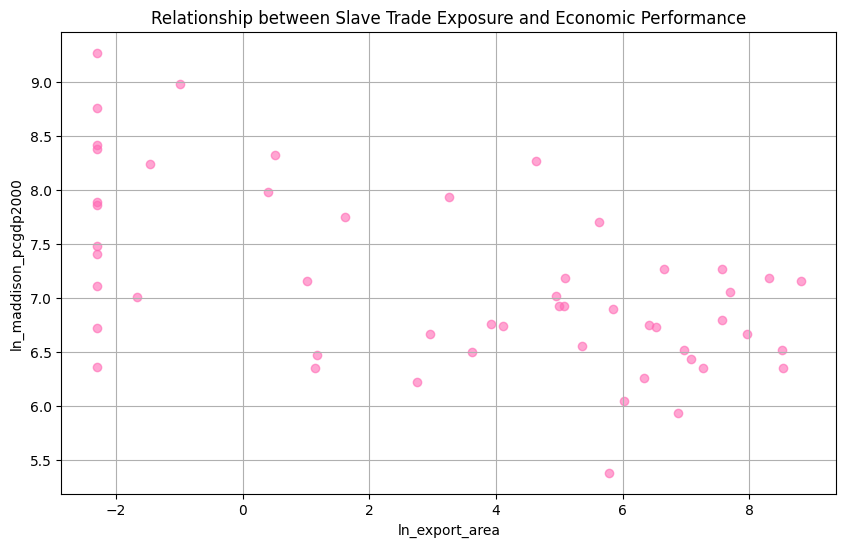

In [19]:
#Examining relationship between slave trade exposure and economic performance- Linear or nonlinear?

import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel('/content/drive/My Drive/slave_trade_QJE_updated.xlsx')

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['ln_export_area'], df['ln_maddison_pcgdp2000'], color='hotpink', alpha=0.6)
plt.xlabel('ln_export_area')
plt.ylabel('ln_maddison_pcgdp2000')
plt.title('Relationship between Slave Trade Exposure and Economic Performance'
)
plt.grid(True)
plt.show()

In [3]:
#First Stage- predicting the slave exports using interaction terms

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

instruments = [
    'atlantic_distance_minimum',
    'indian_distance_minimum',
    'saharan_distance_minimum',
    'red_sea_distance_minimum',
]
interactions = [
    'atlantic_distance_minimum_region_n_interaction',
    'atlantic_distance_minimum_region_s_interaction',
    'atlantic_distance_minimum_region_w_interaction',
    'atlantic_distance_minimum_region_e_interaction',
    'atlantic_distance_minimum_region_c_interaction',
    'indian_distance_minimum_region_n_interaction',
    'indian_distance_minimum_region_s_interaction',
    'indian_distance_minimum_region_w_interaction',
    'indian_distance_minimum_region_e_interaction',
    'indian_distance_minimum_region_c_interaction',
    'saharan_distance_minimum_region_n_interaction',
    'saharan_distance_minimum_region_s_interaction',
    'saharan_distance_minimum_region_w_interaction',
    'saharan_distance_minimum_region_e_interaction',
    'saharan_distance_minimum_region_c_interaction',
    'red_sea_distance_minimum_region_n_interaction',
    'red_sea_distance_minimum_region_s_interaction',
    'red_sea_distance_minimum_region_w_interaction',
    'red_sea_distance_minimum_region_e_interaction',
    'red_sea_distance_minimum_region_c_interaction'
]

instruments_and_interactions = instruments + interactions

# Define your features (instruments and interaction terms) and the target (treatment)
X_stage1 = df[instruments_and_interactions]
y_stage1 = df['ln_export_area']

# Standardize features
scaler = StandardScaler()
X_stage1_scaled = scaler.fit_transform(X_stage1)

# Split the data for the first stage
X_train_stage1, X_test_stage1, y_train_stage1, y_test_stage1 = train_test_split(X_stage1_scaled, y_stage1, test_size=0.2, random_state=42)

# Initialize and fit the regression model
regressor_stage1 = GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=123)
regressor_stage1.fit(X_train_stage1, y_train_stage1)

# Predict 'ln_export_area' using the trained model
predicted_ln_export_area = regressor_stage1.predict(X_stage1_scaled)  # Use on full dataset for stage 2

print(regressor_stage1.predict(X_stage1_scaled))

[ 7.93676491  1.16300774  8.30349459  8.35682447 -2.26635625  4.70462028
  5.14652952  4.90734566  5.55293058 -2.22274318 -2.27332916 -1.65734351
 -0.97069313  1.98958419  7.05504816  4.64947315  8.76896215  8.63390327
  7.55833485  5.61527181 -0.94165528  4.96889032  4.12258988  1.63782707
 -2.26635625 -2.31856852  5.29466366  6.55791495  6.64618182  5.04805726
 -2.28621256  6.92788526 -2.26635625  2.773533    7.7260909  -2.20910426
  5.83317266  7.55822643  6.79551859  3.90427576 -2.28880202 -2.28824404
 -2.26839972  2.64464549  8.49386468 -2.27160125  6.22476805  5.78271387
  0.49183156  5.82910152  2.12745845  1.04218533]


In [10]:
#Second Stage- Estimating the effect of slave exports on economic outcomes BY REGION


from sklearn.linear_model import LassoCV
from econml.dml import CausalForestDML
from sklearn.preprocessing import StandardScaler
import pandas as pd




controls = ['abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area', 'island_dum', 'islam', 'legor_fr', 'ln_avg_oil_pop', 'ln_avg_all_diamonds_pop']

features_for_stage2 = controls

# Map each region to its corresponding column

regions = {
    'region_n': 'region_n',
    'region_s': 'region_s',
    'region_e': 'region_e',
    'region_w': 'region_w',
    'region_c': 'region_c',
}

region_specific_models = {}

for region_name, region_col in regions.items():
    # Filter data for countries in the specific region
    df_region = df[df[region_col] == 1]

    if not df_region.empty:
        # Prepare the feature matrix and outcome variables for the region
        X_region = df_region[features_for_stage2]
        Y_region = df_region['ln_maddison_pcgdp2000']
        T_region = df_region['predicted_ln_export_area']

        # Scale features for the region
        scaler = StandardScaler()
        X_region_scaled = scaler.fit_transform(X_region)

        # Initialize and fit the causal forest model for the region
        model_y_region = LassoCV(max_iter=10000, cv=5, random_state=123)
        model_t_region = LassoCV(max_iter=10000, cv=5, random_state=123)
        causal_forest_region = CausalForestDML(model_y=model_y_region, model_t=model_t_region,
                                               criterion='mse', n_estimators=100,
                                               min_samples_leaf=10, random_state=123)
        causal_forest_region.fit(Y=Y_region, T=T_region, X=X_region_scaled)

        # Store the fitted model in the dictionary
        region_specific_models[region_name] = causal_forest_region
    else:
        print(f"No data available for {region_name}, model not fitted.")

Model LassoCV(cv=5, max_iter=10000, random_state=123) has a non-default cv attribute, which will be ignored
Model LassoCV(cv=5, max_iter=10000, random_state=123) has a non-default cv attribute, which will be ignored
Model LassoCV(cv=5, max_iter=10000, random_state=123) has a non-default cv attribute, which will be ignored
Model LassoCV(cv=5, max_iter=10000, random_state=123) has a non-default cv attribute, which will be ignored
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.839e-03, tolerance: 5.304e-03
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.421e-02, tolerance: 5.815e-03
Model LassoCV(cv=5, max_iter=10000, random_state=123) has a non-default cv attribute, which will be ignored
Model LassoCV(cv=5, max_iter=10000, random_state=123) has a non-de

In [11]:
#Calculate ATE for each region


# Initialize a dictionary to store the ATE for each region
ate_by_region = {}

for region_name, model in region_specific_models.items():
    # Select the data for the current region
    df_region = df[df[regions[region_name]] == 1]

    # Check if the region's dataframe is not empty
    if not df_region.empty:
        X_region = df_region[features_for_stage2]

        # Scale features for the region
        scaler = StandardScaler()
        X_region_scaled = scaler.fit_transform(X_region)

        # Calculate the estimated treatment effects for the region
        treatment_effects_region = model.effect(X_region_scaled)

        # Calculate the average treatment effect for the region
        ate_region = treatment_effects_region.mean()

        # Store the ATE in the dictionary
        ate_by_region[region_name] = ate_region
    else:
        ate_by_region[region_name] = None  # No data available for this region

# Print the ATE for each region
for region, ate in ate_by_region.items():
    if ate is not None:
        print(f"Average Treatment Effect for {region}: {ate:.4f}")
    else:
        print(f"Data not available for {region}, ATE not calculated.")

Average Treatment Effect for region_n: -0.0728
Average Treatment Effect for region_s: -0.1591
Average Treatment Effect for region_e: -0.1288
Average Treatment Effect for region_w: -0.0253
Average Treatment Effect for region_c: -0.0178


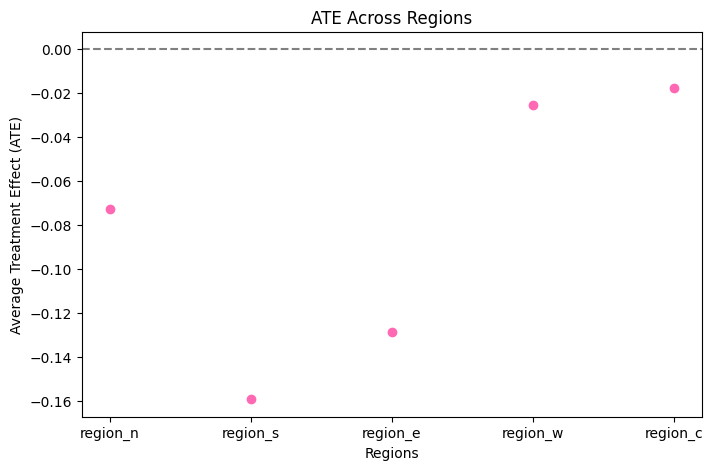

In [18]:
#Graph ATE Across regions

# Assuming the same ate_by_region dictionary for ATE values
ate_by_region = {
    'region_n': -0.0728,
    'region_s': -0.1591,
    'region_e': -0.1288,
    'region_w': -0.0253,
    'region_c': -0.0178
}

# Extract regions and their ATE values for plotting
regions = list(ate_by_region.keys())
ate_values = list(ate_by_region.values())

# Convert region labels into numerical values for scatter plot
region_indices = range(len(regions))

# Create the scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(region_indices, ate_values, color='hotpink')

# Add labels for each region below the x-axis
plt.xticks(region_indices, regions)

# Adding a horizontal line at y=0 for reference
plt.axhline(0, color='grey', linestyle='--')

# Adding labels and title
plt.xlabel('Regions')
plt.ylabel('Average Treatment Effect (ATE)')
plt.title('ATE Across Regions')

plt.show()





In [23]:
#Second Stage- Estimating the effect of slave exports on economic outcomes OVERALL

from sklearn.linear_model import LassoCV
from econml.dml import CausalForestDML
from sklearn.preprocessing import StandardScaler
import pandas as pd

controls = ['abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area', 'island_dum', 'islam', 'legor_fr', 'ln_avg_oil_pop', 'ln_avg_all_diamonds_pop']

features_for_stage2 = controls

#Using predicted values from First Stafe
df['predicted_ln_export_area'] = predicted_ln_export_area


# Prepare your feature matrix X_stage2 including controls
X_stage2 = df[features_for_stage2]

#Define Y_stage2 and T_stage2
Y_stage2= df['ln_maddison_pcgdp2000']
T_stage2= df['predicted_ln_export_area']

# Scale features prior to using Lasso
scaler = StandardScaler()
X_stage2_scaled = scaler.fit_transform(X_stage2)

# Initialize your causal forest model with LassoCV models for both outcome and treatment models
model_y = LassoCV(max_iter=10000, cv=5, random_state=123)
model_t = LassoCV(max_iter=10000, cv=5, random_state=123)

causal_forest_stage2 = CausalForestDML(model_y=model_y, model_t=model_t,
                                       criterion='mse', n_estimators=100,
                                       min_samples_leaf=10, random_state=123)

# Fit the causal forest model using the scaled feature matrix including controls
causal_forest_stage2.fit(Y=Y_stage2, T=T_stage2, X=X_stage2_scaled)

Model LassoCV(cv=5, max_iter=10000, random_state=123) has a non-default cv attribute, which will be ignored
Model LassoCV(cv=5, max_iter=10000, random_state=123) has a non-default cv attribute, which will be ignored


In [13]:
#Calculate ATE across ALL OBSERVATIONS

import numpy as np

# Obtain treatment effect estimates
treatment_effects = causal_forest_stage2.effect(X_stage2_scaled)

average_treatment_effect = np.mean(treatment_effects)
print(f"Average Treatment Effect: {average_treatment_effect}")

lower, upper = causal_forest_stage2.effect_interval(X_stage2_scaled, alpha=0.05)



Average Treatment Effect: -0.08162406477815415
